Europos atvirų duomenų portalas (EDP) atsiuntė klausimyną, kurio pagalba vertins
atvirų duomenų progresą Lietuvoje. Aš gavau užduotį paanalizuoti [Lietuvos
atvirų duomenų katalogo](https://data.gov.lt/) (ADK) duomenis ir atsakyti į kai
kuriuos klausimyno klausimus.

Įdomu, kodėl EDP pats nepasianalizuoja duomenų, kadangi data.gov.lt esantys
duomenų rinkiniai yra atviri ir
[suimportuoti](https://www.europeandataportal.eu/data/datasets?catalog=data-gov-lt)
į EDP?

ADK viešojo API [dokumentacija](https://data.gov.lt/public/api/1) rašo, kad API
įgyvendina tik vieną API prieigos tašką
[package_search](https://data.gov.lt/public/api/1/action/package_search). Kuris
kaip suprantu atitinka CKAN
[package_search](https://docs.ckan.org/en/2.9/api/#ckan.logic.action.get.package_search),
o pats [CKAN](https://ckan.org/) po dangčiu naudoja
[SOLR](https://lucene.apache.org/solr/guide/6_6/common-query-parameters.html).
Kad suprasti kaip naudoti API reikėtų peržiūrėti visų trijų projektų
dokumentacijas.


# Duomenų surinkimas

Bandau žiūrėti ką grąžina API prieigos taškas:

In [41]:
!http -b 'https://data.gov.lt/public/api/1/action/package_search?rows=1'

{
    "help": "https://data.gov.lt/public/api/1/action/help_show?name=package_search",
    "result": {
        "count": 1,
        "results": [
            {
                "author": "",
                "authorEmail": "",
                "creatorUserId": "",
                "id": "{24C009EF-BD65-1890-F505-D0FBB3C16F43}",
                "is_open": false,
                "metadata_created": "2020-06-10T11:16:37",
                "metadata_modified": "2020-08-05T13:00:54",
                "notes": "Lietuvos nacionalinio atlaso žemėlapis - „Paros vidutinė oro temperatūra pakyla aukščiau ir nukrinta žemiau 0°C“. Autorius:A. Bukantis. Kartografas: G. Reginienė. Žemėlapis priklauso Nacionalinio atlaso skyriui - \"Gamta ir kraštovaizdis\", temai - \"Klimatas\"",
                "numResources": 0,
                "numTags": 0,
                "open": false,
                "private": false,
                "state": "active",
                "title": "WMS. Lietuvos nacionalinio atlaso žemėlapi

Duomenų mažoka ir matosi, kad jei tam tikrų duomenų nėra, tai jie nėra
įtraukti į atsakymą. Man nepatinka, kai API prieigos taškas grąžina duomenis,
kuriuose dalykai tai atsiranda, tai pranyksta. Apsunkina duomenų interpretavimą.

Dokumentacijoje paminėta, kad palaikomas puslapiavimas. Bandysiu pasinaudoti
šia galimybe ir susirinkti visus duomenis nedideliais gabalais.

In [52]:
import requests

def get_datasets(ckan, start=0, rows=50):
    start: int = 0
    rows: int = 50
    datasets = []
    while True:
        url = f'{ckan}/action/package_search'
        resp = requests.get(url, params={
            'rows': rows,
            'start': start,
        })
        assert resp.ok, resp.url
        results = resp.json()['result']['results']
        if results:
            datasets += results
            start += rows
        else:
            break
    return datasets

datasets = get_datasets('https://data.gov.lt/public/api/1')

Veikia, žiūrim ar duomenų rinkinių skaičius sutampa su tuo, kas rodoma
data.gov.lt svetainėje.

In [2]:
len(datasets)

959

Sutampa. Kitas klausimas, kaip išsiaiškinti kokia yra duomenų
schema? Bandau automatiškai gauti schema tikrinant kokie laukai naudojami
visuose įrašuose:

In [42]:
def inspect(value, keys=()):
    if isinstance(value, dict):
        for k, v in value.items():
            yield from inspect(v, keys + (k,))
    elif isinstance(value, list):
        for v in value:
            yield from inspect(v, keys[:-1] + (keys[-1] + '[]',))
    else:
        yield '.'.join(keys)

def get_schema(rows):
    schema = set()
    for row in rows:
        schema.update(inspect(row))
    return schema

schema = get_schema(datasets)
print(*sorted(schema), sep='\n')

TypeError: 'NoneType' object is not iterable

Schema pakankamai aiški, yra dvi lentelės, duomenų rinkinių ir resursų. Tik
neaišku, kas slepiasi po `extras`. Žiūrim:

In [4]:
{x['key'] for d in datasets for x in d.get('extras', [])}

{'structure'}

Supratau, `extras` yra papildomi duomenys ir konkrečiai `structure` yra
duomenų struktūros lentelės, kurių panašu gali būti daugiau nei viena, nors
turėtu būti tik viena.

Matyt reikės `extras` interpretuoti kaip dar vieną lentelę.

Kad būdų patogiau dirbti su duomenimis konvertuoju viską į
[pandas](https://pandas.pydata.org/) duomenų struktūras:

In [5]:
import pandas as pd

def fix_dates(dates):
    for t, dates_ in dates.items():
        t = tables[t]
        for d in dates_:
            t[d] = pd.to_datetime(t[d])


tables = {
    'datasets': [],
    'resources': [],
    'extras': [],
}
for d in datasets:
    tables['datasets'] += [{
        k: v
        for k, v in d.items() if k not in ('resources', 'extras')
    }]

    tables['resources'] += [
        {
            **r,
            'dataset': d['id'],
        }
        for r in d.get('resources', [])
    ]

    tables['extras'] += [
        {
            x['key']: x['value'],
            'dataset': d['id'],
        }
        for x in d.get('extras', [])
    ]

tables = {k: pd.DataFrame(v) for k, v in tables.items()}

fix_dates({
    'datasets': [
        'metadata_created',
        'metadata_modified',
    ],
    'resources': [
        'cache_last_updated',
        'last_modified',
    ],
})

Duomenys paruošti naudojimui, žiūrim ką turim.

Duomenų rinkiniai:

In [6]:
tables['datasets'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959 entries, 0 to 958
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 959 non-null    object        
 1   author             959 non-null    object        
 2   authorEmail        959 non-null    object        
 3   state              959 non-null    object        
 4   version            959 non-null    object        
 5   creatorUserId      959 non-null    object        
 6   type               959 non-null    object        
 7   numResources       959 non-null    int64         
 8   numTags            959 non-null    int64         
 9   title              959 non-null    object        
 10  notes              959 non-null    object        
 11  name               355 non-null    object        
 12  private            959 non-null    bool          
 13  open               959 non-null    bool          
 14  metadata_c

Resursai:

In [7]:
tables['resources'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   mimetype            0 non-null      object        
 1   hash                0 non-null      object        
 2   description         977 non-null    object        
 3   name                977 non-null    object        
 4   format              965 non-null    object        
 5   url                 978 non-null    object        
 6   created             978 non-null    object        
 7   state               0 non-null      object        
 8   position            978 non-null    int64         
 9   id                  965 non-null    object        
 10  size                0 non-null      object        
 11  cache_url           0 non-null      object        
 12  datastore_active    978 non-null    bool          
 13  cache_last_updated  0 non-null      datetime64[ns]

Keista, `resources` lentelėje, daugiau kaip pusė duomenų laukų neturi
reikšmių, įdomu kodėl taip yra?

Extras:

In [8]:
tables['extras'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   structure  367 non-null    object
 1   dataset    367 non-null    object
dtypes: object(2)
memory usage: 5.9+ KB


Viskas atrodo neblogai, dabar galima pereiti prie EDP klausimyno klausimų.

Bet prieš tai, noriu atkreipti dėmesį, kodėl reikalingas atvertų duomenų
struktūros aprašas, tam, kad nereikėtų daryti to, ką aš ką tik padariau. T. y.
kad nereikėtų klaidžioti po duomenis, bandant suprasti kas juose yra, tai turėtų
matytis duomenų struktūros apraše, kuris turėtų būti pateikiamas kartu su
duomenimis.


Atsakymai europos duomenų portalui
==================================

Iš klausimyno man reikia atsakyti tik į 4 dalies, apie atvirų duomenų kokybę,
klausimus (Dimension 4: Open Data Quality).

> 4.1 Currency and completeness

EDP klausimyne yra keletas klausimų apie duomenų metaduomenų atnaujinimo
dažnumą. Manau iš turimų duomenų nelabai galima atsakyti į tuos klausimus, todėl
tiesiog pabandysiu pažiūrėti į `datasets.metadata_created` ir
`datasets.metadata_modified` duomenis, kurie turėtų rodyti kada duomenų
rinkiniai buvo paskutinį kartą atnaujinti.

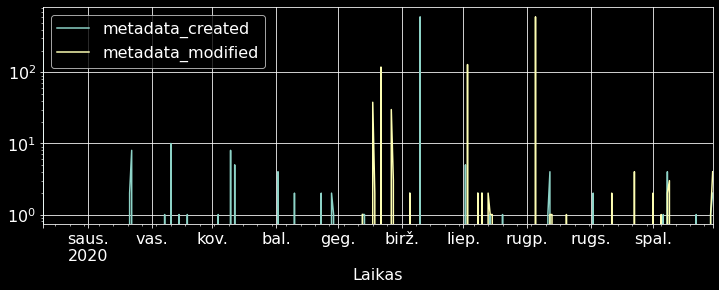

In [40]:
%matplotlib inline

import locale
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

locale.setlocale(locale.LC_TIME, 'lt_LT.UTF-8')
plt.style.use('dark_background')
mpl.rc('font', size=16)

dates = {}
for c in ('metadata_created', 'metadata_modified'):
    d = tables['datasets'][c].dropna()
    d = pd.Series(np.ones(d.shape), index=d)
    dates[c] = d.resample('D').count()
df = pd.DataFrame(dates)
df.index.name = "Laikas"
df.plot(logy=True, grid=True, figsize=(12, 4));

Sunku pasakyti ką iš to galima spręsti. Matosi, kad duomenų rinkinių
metaduomenys kartais atnaujinami. O nuorodos į atvertus duomenis panašu, kad
neatnaujinamos visai, nes nėra nei vienos atnaujinimo datos:

In [10]:
tables['resources'][['cache_last_updated', 'last_modified']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   cache_last_updated  0 non-null      datetime64[ns]
 1   last_modified       0 non-null      datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 15.4 KB


Klausimas ar resursų metaduomenys niekada nebuvo atnaujinti ar čia kažkokia
klaida *data.gov.lt* pusėje?

> 12\. What percentage of the open data available on the national portal is
> accompanied by licensing information?

Peržiūrėjau struktūrą, bet nematau jokių duomenų laukų apie licenciją. Taip pat
negaliu atsakyti ir į kitus klausimus susijusius su licencijos naudojimu.

> 18\. What is the percentage of metadata on your portal that is DCAT-AP
> compliant, in terms of mandatory classes? (agent, catalogue, data set,
> literal, resource)

Kiek žinau pačiame atvirų duomenų kataloge yra galimybė pateikti visas šias
klases, bet per katalogo viešąjį API yra prieinami duomenys tik apie **data
set** ir **resource**. Todėl nėra galimybė atsakyti į šį ir kitus panašius
klausimus.

> 23\. What is the percentage of data sets whose metadata provides a reference
> to where the data can be downloaded, or its API accessed (“download-URL” in
> the DCAT-AP specification)?

In [11]:
with_links = tables['resources'][(
    tables['resources'].url.notnull() &
    tables['resources'].url.str.len() > 0
)]
downloadable = len(with_links.dataset.unique())

100 / len(tables['datasets']) * downloadable

18.873826903023982

Iš visų duomenų rinkinių tik 19% rinkinių turi duomenų atsisiuntimo nuorodas.

Įdomu, kiek iš viso yra nuorodų į pačius duomenis?

In [12]:
len(with_links)

572

Įdomu, kiek iš visų šių nuorodų yra veikiančios?

In [13]:
import warnings

from collections import Counter
from concurrent.futures import ThreadPoolExecutor
from requests.packages.urllib3.exceptions import InsecureRequestWarning

warnings.simplefilter('ignore', InsecureRequestWarning)

def check_link(link):
    if link.startswith(('http://', 'https://')):
        try:
            return requests.head(
                link,
                timeout=30,
                verify=False,
                allow_redirects=True,
            ).status_code
        except Exception as e:
            return type(e).__name__
    else:
        return 'non-http'

with ThreadPoolExecutor(max_workers=100) as executor:
    results = executor.map(check_link, with_links.url)
    for k, v in Counter(results).most_common():
        print(f"{k:>16}: {v:>3}")

             200: 416
     ReadTimeout: 155
        non-http:   1


Panašų, kad apie 155 nuorodos neveikia arba nesugebėjo duoti atsakymo į HEAD
užklausą per 30 sekundžių.

> 28\. What percentage of datasets is made available under a standard open
> licence or an explicit custom open licence, in any data format including
> text documents?

Kadangi duomenų apie licenciją nėra, tai galima teigti, kad visi duomenys
kataloge prieinami pagal atvirą licenciją. T.y. atsakymas į šį klausimą yra 19%.

> 30\. Of the percentage indicated in the previous question (Question 28), what
> percentage of datasets is made available under a standard open licence or an
> explicit custom open licence, in a structured data format?

Ta pati situacija, dėl to, kad nėra duomenų apie licenciją. Atsakymas į šį
klausimą yra 100%.

> 31\. Of the percentage indicated in the previous question (Question 30),
> which part is also in an open and machine-readable format?

Kad atsakyti į šį klausimą, pirmiausiai žiūrim kokie formatai iš vis pasiekiami:

In [14]:
tables['resources'].format.value_counts()

CSV     953
XLSX      8
XLS       2
JSON      1
PDF       1
Name: format, dtype: int64

In [15]:
tables['resources'].mimetype.value_counts()

Series([], Name: mimetype, dtype: int64)

In [16]:
tables['resources'].resource_type.value_counts()

Series([], Name: resource_type, dtype: int64)

In [17]:
tables['resources'].url_type.value_counts()

Series([], Name: url_type, dtype: int64)

Nežinau kokia `mimetype`, `resource_type` ir `url_type` laukų paskirtis, bet
panašu, kad jie nenaudojami, todėl norint nustatyti kiek duomenų rinkinių
teikiami atvirais formatais remsiuosi `format` stulpelio duomenimis.

In [18]:
100 / downloadable * len(tables['resources'][
    tables['resources'].format.isin(['CSV', 'JSON'])
].dataset.unique())

183.9779005524862

Įdomu. Kaip suprantu dalyje duomenų rinkinių deklaruojama, kad duomenys teikiami
atvirais formatais, bet nuorodų į pačius duomenis nėra. Gal toks procentas
dėl to, kad dalis duomenų dar nėra atverti, bet planuojama juos atverti?

Bandom pasižiūrėti, kiek atvirų formatų iš duomenų, kuriuos galima atsisiųsti.

In [19]:
100 / downloadable * len(tables['resources'][(
    tables['resources'].url.notnull() &
    tables['resources'].url.str.len() > 0 &
    tables['resources'].format.isin(['CSV', 'JSON'])
)].dataset.unique())

100.0

Taip išeina, kad visi duomenys, kuriuos galima atsisiųsti teikiami atvirais
formatais.

> 32\. Of the percentage indicated in the previous question (Question 31), what
> percentage of datasets also consistely use Uniform Resource Identifiers?

> 33\. Of the percentage indicated in the previous question (Question 32), what
> percentage of datasets also links to other renowned sources to provide
> additional context for the users, e.g. in a linked data fashion?

Tokių duomenų taip pat nėra. Kiek žinau, pirmas duomenų atvėrimo etapas
apsiribojo tik trečiuoju brandos lygiu, todėl atsakymas į 32 ir 33 klausimus
yra 0%.

Mano planuose, II duomenų atvėrimo etape taisyti šią situaciją ir kiek
įmanoma duomenis atverti 5 brandos lygiu ir tai nėra taip jau sudėtinga.

Čia buvo paskutinis klausimyno klausimas, deja į dalį klausimų nėra galimybės
atsakyti, nes nėra pakankamai duomenų, bent jau prieinamų per viešąjį
data.gov.lt API.


Trūkstami duomenys
==================

Išsiaiškinau, kad pasirodo data.gov.lt sukasi ne ant CKAN, o ant nuo nulio
perdaryto CKAN analogo ir API yra ne CKAN API, o į CKAN panašus API.

Ką gi, bandau aiškintis, kokių laukų trūksta. Tam reikalui panaudosiu
demo.ckan.org ir palyginsiu jo schema su data.gov.lt.

In [53]:
ckan_datasets = get_datasets('https://demo.ckan.org/api/3')
ckan_schema = get_schema(ckan_datasets)
missing = ckan_schema - schema
print(*sorted(missing), sep='\n')

author_email
creator_user_id
groups[].description
groups[].display_name
groups[].id
groups[].image_display_url
groups[].name
groups[].title
isopen
license_id
license_title
license_url
maintainer
maintainer_email
num_resources
num_tags
organization
organization.approval_status
organization.created
organization.description
organization.id
organization.image_url
organization.is_organization
organization.name
organization.revision_id
organization.state
organization.title
organization.type
owner_org
resources[].BET
resources[].alternates
resources[].bq_table_id
resources[].bq_table_name
resources[].bytes
resources[].calcination_protocol
resources[].capability_node
resources[].characterSet
resources[].collection_date
resources[].comments
resources[].data_correctness
resources[].data_source
resources[].data_source_type
resources[].datafile-date
resources[].density
resources[].distribution_format
resources[].encoding
resources[].extra_key
resources[].file
resources[].files
resources[].form
res

Išvada
======

Pašnekėjus su Atea, kurie kūrė data.gov.lt sužinojau įdomių dalykų. Pasirodo
data.gov.lt pastatytas ne ant CKAN, o perrašytas nuo nulio. Tai reiškia, kad
data.gov.lt projektas iš esmės yra miręs. Nes po kažkiek laiko baigsis
palaikymo sutartis, o technologijos judės į priekį, data.gov.lt nebus nei
tobulinamas, nei atnaujinamas, tai reiškia, kad jis galiausiai bus išmestas.

Dar išsiaiškinau, kad viso yra tokie data.gov.lt API šaltiniai:

- [Viešasis API](https://data.gov.lt/public/api/1).
- [Duomenų dumpas](https://data.gov.lt/edp/dcat-ap.rdf) skirtas EDP, jis yra
  viešas, bet neviešinamas.
- [SPARQL prieigos taškas](https://data.gov.lt/sparql), kuriame prieinami tik
  ADK metaduomenys, bet ne patys duomenys.
- Ir dar yra vidinis tiekėjų API, kurio dar neteko matyti.

Kas liečia atvirų duomenų brandos lygį, geriausiu atveju duomenys teikiami
trečiuoju brandos lygiu ir toks reikalavimas buvo įrašytas į techninę
specifikaciją, jei gerai atsimenu.

Žodžiu yra labai daug vietos kur galima tobulėti.